In [1]:
# !pip install patool
# import patoolib
# # patoolib.extract_archive("isic-2020-resized.zip")
# patoolib.extract_archive("train-resized.zip")
# patoolib.extract_archive("test-resized.zip")

In [2]:
#Imports
!pip3 install tqdm
import numpy as np
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split,WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
from torchvision.io import read_image
from torchvision.models import resnet50
from collections import Counter

In [3]:
#create csv file for test
csv_exist=False
if not csv_exist:
    img_dir="./test-resized"
    with open('test-name.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["name"]
        writer.writerow(field)
        for x in os.listdir(img_dir):
            writer.writerow([os.path.splitext(x)[0]])
    print("Done!")

Done!


In [4]:
#Chargement des données
#Définition des classes
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.target=torch.tensor(self.img_labels.iloc[:, 1])
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        #preprocess img
        image=image.float()
        image *= (1.0/image.max())
        label = self.img_labels.iloc[idx, 1]
        label=torch.tensor(float(label)) #preprocess label
        
        if label.item()==1. and self.transform:
            image = self.transform(image)
        
        
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label
    
class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0]+".jpg")
        image = read_image(img_path)
        name=self.img_name.iloc[idx,0]
        image=image.float()
        image *= (1.0/image.max())
        if self.transform:
            image = self.transform(image)
        return image,name

print("Done")

Done


In [5]:
dataset=CustomImageDataset(annotations_file='./train-labels.csv',img_dir='./train-resized')
print(dataset[0][1])

tensor(0.)


In [6]:
# #Chargement des données
# #Instanciation des dataloaders
# # Define data augmentation transforms
# data_augmentation = transforms.Compose([
#     transforms.RandomRotation(10),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
# ])
dataset=CustomImageDataset(annotations_file='./train-labels.csv',img_dir='./train-resized',)
generator1 = torch.Generator().manual_seed(42)
l=len(dataset)


# augment = 0
# if augment :
    
#     # Create an addtion class 1 from all data
#     class1_samples = [dataset[i] for i in range(l) if dataset[i][1] == 1]

#     # Apply data augmentation to class 1 samples and add to train_dataset
#     dataset += [(data_augmentation(sample[0]), 1) for sample in class1_samples]
#     l=len(dataset)
#     # print([d[:][1] for d in dataset])
#     # _,_,count=torch.unique((d[:][1] for d in dataset),return_counts=True)
#     # print(f"Classe du dataset train+val : {count}\n-------------------------------")
# else:
#     print(f"Classe du dataset train+val : {torch.unique(dataset.target, return_counts=True)}\n-------------------------------")

train_dataset,val_dataset=random_split(dataset, [int(l - (l // 10)), int(l // 10)], generator=generator1)
test_dataset=CustomImageTestset(annotations_file='./test-name.csv',img_dir='./test-resized')


label_train = [train_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices]
class_sample_count = np.array([len(np.where(label_train == t)[0]) for t in np.unique(label_train)])
print(f"Classe du dataset train : {dict(Counter(val_dataset.dataset.img_labels.iloc[i,1] for i in train_dataset.indices))}\n-------------------------------")



Classe du dataset train : {0: 29302, 1: 512}
-------------------------------


In [7]:
#Mise en forme des données

batch_size = 64
num_workers = 3
#distribue les classes dans chaque sample
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in label_train])
samples_weight = torch.from_numpy(samples_weight)
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight),replacement=True)
samp=1
# Create data loaders.
if samp:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers,sampler=sampler)
else:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers)
    
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
val_dataloader=DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=num_workers)

for X,y in train_dataloader:
    print(f"Classe du batch : {np.array([len(torch.where(y == t)[0]) for t in torch.unique(y)])}\n-------------------------------")
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Classe du batch : [31 33]
-------------------------------
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.float32


In [8]:
# Création du modèle
import torchvision.models as models #import resnet18, ResNet18_Weights
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

# Define model
model = models.resnet50(pretrained=True)
#freeze params
for params in model.parameters():
  params.requires_grad_ = False

model= model.cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.fc = model.fc.cuda()  if device=="cuda" else net.fc
# print(model)

Using cuda device


In [9]:
#défini la fonction de perte et l'optimiseur
pos_weight=torch.tensor(class_sample_count[0]/class_sample_count[1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

In [10]:
#val
def val(model,loss_fn,val_dataloader,csv_file,send,loss=None,nb="Last"):
    val_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    num_batches = len(val_dataloader)
    
    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for val_batch, (val_X, val_y) in enumerate(val_dataloader):
            val_X, val_y = val_X.to(device), val_y.to(device)
            val_pred = model(val_X)
            val_loss += loss_fn(val_pred.squeeze(), val_y).item()
            # Calculate accuracy for each class
            predicted_labels=torch.sigmoid(val_pred.T)
            correct_predictions_0 += ((val_y == 0) & (predicted_labels < 0.5)).sum().item()
            correct_predictions_1 += ((val_y == 1) & (predicted_labels >= 0.5)).sum().item()
            total_samples_0 += (val_y == 0).sum().item()
            total_samples_1 += (val_y == 1).sum().item()
 
        accuracy_0 = correct_predictions_0 / total_samples_0
        accuracy_1 = correct_predictions_1 / total_samples_1
        accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
        avg_val_loss = val_loss / (val_batch + 1)
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            if loss==None:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3)]+send)
            else:
                writer.writerow([nb,round(accuracy_gen,3),round(accuracy_0,3),round(accuracy_1,3),round(avg_val_loss,3),torch.round(loss,decimals=3).item()]+send)
    

In [11]:
# fonction qui calcule la précision de validation
def calculate_val_accuracy():
    model.eval()  # mettre le modèle en mode d'évaluation
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()  # remettre le modèle en mode d'entraînement
    return correct / total
#training

# Initialisation
best_val_accuracy = 0
patience = 2
epochs_no_improve = 0

epochs=5
nb_batch=len(train_dataloader)
print(f"Number of batches : {nb_batch}\n-------------------------------")
with open('val'+str(batch_size)+'.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["epoch","gen acc","acc0","acc1","val_loss","loss","acc0_train","acc1_train","accGen_train"]
    writer.writerow(field)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    for batch, (X, y) in tqdm(enumerate(train_dataloader), total=nb_batch):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # ---------------------------------------------------------------------------
    total_samples_0 = 0
    total_samples_1 = 0
    correct_predictions_0 = 0
    correct_predictions_1 = 0
    predicted_labels=torch.sigmoid(pred.T)
    correct_predictions_0 += ((y == 0) & (predicted_labels < 0.5)).sum().item()
    correct_predictions_1 += ((y == 1) & (predicted_labels >= 0.5)).sum().item()
    total_samples_0 += (y == 0).sum().item()
    total_samples_1 += (y == 1).sum().item()
    accuracy_0 = correct_predictions_0 / total_samples_0
    if tota
        accuracy_1 = correct_predictions_1 / total_samples_1
    accuracy_gen= (correct_predictions_0+correct_predictions_1) / (total_samples_0+total_samples_1)
    #--------------------------------------------------------------------------------
    send = [accuracy_0,accuracy_1,accuracy_gen]
    val(model,loss_fn,val_dataloader,'val'+str(batch_size)+'.csv',send,loss=loss,nb=t)
        # if batch+1 % round((nb_batch-1)/3) == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    # Calcul de la précision de validation
#     val_accuracy = calculate_val_accuracy()

#     # Vérifiez si la précision de validation a augmenté
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         epochs_no_improve = 0
#         # Sauvegardez le modèle
#         torch.save(model.state_dict(), 'best_model.pt')
#     else:
#         epochs_no_improve += 1
#         # Arrêtez l'entraînement si la précision de validation ne s'améliore pas pendant 'patience' époques
#         if epochs_no_improve == patience:
#             print('Early stopping!')
#             break
        
        
print("Done!")


Number of batches : 466
-------------------------------
Epoch 1
-------------------------------


100%|██████████| 466/466 [05:01<00:00,  1.54it/s]


Epoch 2
-------------------------------


100%|██████████| 466/466 [05:02<00:00,  1.54it/s]


Epoch 3
-------------------------------


100%|██████████| 466/466 [05:02<00:00,  1.54it/s]


Epoch 4
-------------------------------


100%|██████████| 466/466 [05:02<00:00,  1.54it/s]


Epoch 5
-------------------------------


100%|██████████| 466/466 [05:02<00:00,  1.54it/s]


Done!


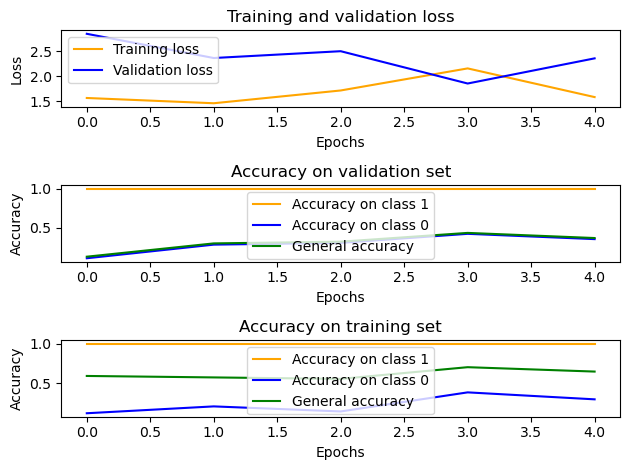

In [12]:
#Visualize data

figure, axis = plt.subplots(3, 1)
csv_file=pd.read_csv('val'+str(batch_size)+'.csv')
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='orange', label='Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["gen acc"], 'g', label='General accuracy')
axis[1].set_title('Accuracy on validation set')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()

axis[2].plot(csv_file["epoch"], csv_file["acc1_train"], color='orange', label='Accuracy on class 1')
axis[2].plot(csv_file["epoch"], csv_file["acc0_train"], 'b', label='Accuracy on class 0')
axis[2].plot(csv_file["epoch"], csv_file["accGen_train"], 'g', label='General accuracy')
axis[2].set_title('Accuracy on training set')
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Accuracy')
axis[2].legend()

plt.tight_layout()
plt.savefig("Metrics"+str(batch_size)+".png")
plt.show()

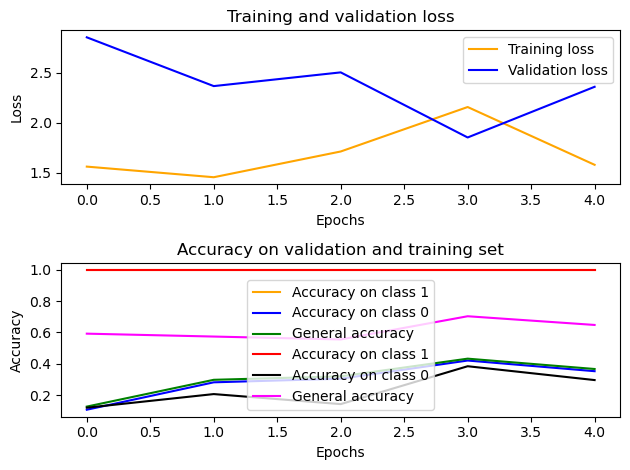

In [13]:
#Visualize data

figure, axis = plt.subplots(2, 1)
csv_file=pd.read_csv('val'+str(batch_size)+'.csv')
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend()

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='orange', label='Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["gen acc"], 'g', label='General accuracy')
axis[1].plot(csv_file["epoch"], csv_file["acc1_train"], color='red', label='Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0_train"], color='black', label='Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["accGen_train"], color='magenta', label='General accuracy')
axis[1].set_title('Accuracy on validation and training set')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].legend()


plt.tight_layout()
plt.savefig("Metrics"+str(batch_size)+".png")
plt.show()

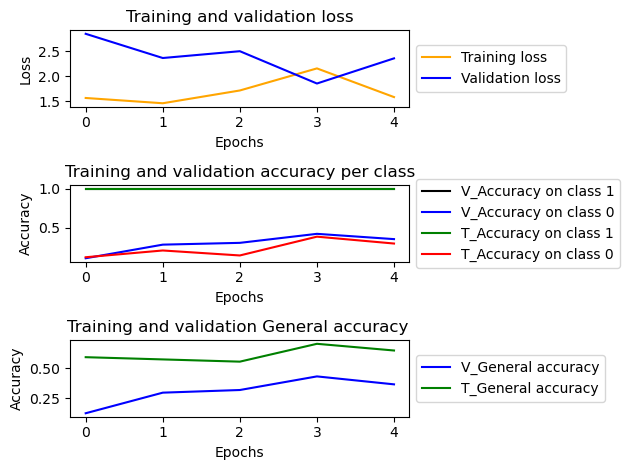

In [21]:
#Visualize data

figure, axis = plt.subplots(3, 1)
csv_file=pd.read_csv('val'+str(batch_size)+'.csv')
axis[0].plot(csv_file["epoch"], csv_file["loss"], color='orange', label='Training loss')
axis[0].plot(csv_file["epoch"], csv_file["val_loss"], 'b', label='Validation loss')
axis[0].set_title('Training and validation loss')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axis[1].plot(csv_file["epoch"], csv_file["acc1"], color='black', label='V_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0"], 'b', label='V_Accuracy on class 0')
axis[1].plot(csv_file["epoch"], csv_file["acc1_train"], color='green', label='T_Accuracy on class 1')
axis[1].plot(csv_file["epoch"], csv_file["acc0_train"], color='red', label='T_Accuracy on class 0')
axis[1].set_title('Training and validation accuracy per class')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')

axis[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


axis[2].plot(csv_file["epoch"], csv_file["gen acc"], 'b', label='V_General accuracy')
axis[2].plot(csv_file["epoch"], csv_file["accGen_train"], 'g', label='T_General accuracy')
axis[2].set_title('Training and validation General accuracy ')
axis[2].set_xlabel('Epochs')
axis[2].set_ylabel('Accuracy')
axis[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig("Metrics"+str(batch_size)+".png")
plt.show()

In [14]:
#test

num_batches = len(test_dataloader)
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    with open('test'+str(batch_size)+'.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        field = ["image_name","target"]
        writer.writerow(field)
        for test_batch, (test_X, name) in tqdm(enumerate(test_dataloader)):
            test_X = test_X.to(device)
            test_pred = model(test_X)
            predicted_labels=torch.sigmoid(test_pred)
           
            for i,x in enumerate(predicted_labels) :
                # print(test_batch)
                # print(i)
                writer.writerow([name[i],round(x.item(),3)])
                # if x.item() >=0.5:
                #     writer.writerow([name[i],1])
                # else: 
                #     writer.writerow([name[i],0])

172it [00:31,  5.51it/s]
